In [1]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };
    
    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }
        
        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

In [2]:
#import necessary libraries
import os
import IPython
import librosa as lr
import numpy as np
from datetime import datetime
from packaging import version
import tensorboard
import keras
from keras import layers
from keras import regularizers
import tensorflow as tf
import matplotlib.pyplot as plt
from librosa import display
from tensorflow.keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Flatten,Dense,Activation,Conv2DTranspose
import time
from sklearn import preprocessing

#LOG_DIR = f'{int(time.time())}'

path = 'C:/Users/erikv/Desktop/IP/samples/' #path where the samples are stored'''
dirs = os.listdir(path) #open the directory using os library'''

def rosaspec(sound, NFFT): #defined functions for extracting the spectogram of a sound wave'''
    sound = np.concatenate((np.zeros(int(NFFT/2)),sound,np.zeros(int(NFFT/2))))
    spec_c = lr.stft(sound, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
    return np.concatenate((np.expand_dims(np.real(spec_c),2),np.expand_dims(np.imag(spec_c),2)),axis=2)

def irosaspec(spec,NFFT): #defined function for extracting a soundwave from a spectogram'''
    spec_c = spec[:,:,0].squeeze() + 1j* spec[:,:,1].squeeze()
    return lr.istft(spec_c, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)[int(NFFT/2):-int(NFFT/2)]

In [3]:
NFFT =  int(1022/8) #selection of the NFFT, allows the modification of the sie of 2nd array dimension'''

batchsize = len(dirs) #selection of the batch size'''
testsize = int(0.2*batchsize) #selection of the test batch file'''

yoriginal1,sroriginal1 = lr.load(path+dirs[35],sr=2*8000) #open the audio file (in this case the 
                                                         #test one) using the librosa library'''
yoriginal1 = yoriginal1[0:int(len(yoriginal1)/16)] #cropping of the loaded file to half the length for testing purposes'''
#originalspect = lr.stft(yoriginal1, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
asignal = np.array([rosaspec(yoriginal1,NFFT)]) #spectogram extraction from the file'''
audio = asignal#/asignal.max() #normalized values to be between 0 and 1
test= audio


print (test.shape,test.max())

(1, 64, 64, 2) 15.121327104970701


In [4]:
starting = irosaspec(test[0],NFFT)
IPython.display.display(IPython.display.Audio(starting,rate = sroriginal1)) #check if the audio has been correctly loaded

In [5]:
xtrain = np.load('processedshorter.npy')

In [6]:
xtrain.shape

(4096, 64, 64, 2)

In [7]:
device = 'cuda'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) #check if keras is using GPU optimization
if test[0,20,20,0] == xtrain[35,20,20,0]: #if these two numbers are the same the files are coincident and correct loading
    print ('--------------loading correct--------------')
else:
    print('--------------loading failed. check coordinates--------------') 

Num GPUs Available:  1
--------------loading correct--------------


In [8]:
autoencoder = tf.keras.models.load_model('autoencoder_v26')
encoder = autoencoder.get_layer('encoder')
decoder = autoencoder.get_layer('decoder')

tried = encoder(np.array([xtrain[2]]))
encodedxtrain = np.zeros([batchsize,2048]) 
for i in range(4096):
    encodedxtrain[i] = encoder(np.array([xtrain[i]]))
print (encodedxtrain.shape)

In [9]:
xtrainencoded = np.load('xtrainencoded.npy')
xtrainencoded.shape

(4096, 2048)

In [11]:
k = 8
shortenerinput = keras.Input(shape=(2048), name="encoded vector")
shorteneroutput = layers.Dense(2**(k),activation='LeakyReLU')(shortenerinput) 

shortener = keras.Model(shortenerinput, shorteneroutput, name="shortener")
shortener.summary()

reshaperinput = keras.Input(shape=(2**k), name="shortened vector")
x = layers.Dense(2048, activation='LeakyReLU')(reshaperinput) 
reshaperoutput = layers.Dense(2048)(x)  

reshaper = keras.Model(reshaperinput, reshaperoutput, name="reshaper")
reshaper.summary()

visualizerinput = keras.Input(shape=(2048), name="input")
shortened = shortener(visualizerinput)
reshaped = reshaper(shortened)
visualizer = keras.Model(visualizerinput, reshaped, name="visualizer")
visualizer.summary()

Model: "shortener"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoded vector (InputLayer)  [(None, 2048)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               524544    
Total params: 524,544
Trainable params: 524,544
Non-trainable params: 0
_________________________________________________________________
Model: "reshaper"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
shortened vector (InputLayer [(None, 256)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              526336    
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              4196352   
Total params: 4,722,688
Trainable

In [12]:
visualizer.compile(optimizer='adam', 
                  loss='mean_squared_error') #the autoencoder is optimizwed using adam and the loss 
                                                              #and metrics are mean logarithmic squared error
visualizer.fit(xtrainencoded,xtrainencoded,
                epochs=200,
                batch_size=20,
                shuffle=True,
                validation_split=0.2) #it is trained using a 20% validations. So from the 100 files batch, 80 are for 
                                      #training and 20 are for validation purposes

Epoch 1/200
164/164 [==============================] - 2s 8ms/step - loss: 3.7860 - val_loss: 1.7669
Epoch 2/200
164/164 [==============================] - 1s 6ms/step - loss: 1.9697 - val_loss: 1.3611
Epoch 3/200
164/164 [==============================] - 1s 6ms/step - loss: 1.6232 - val_loss: 1.7059
Epoch 4/200
164/164 [==============================] - 1s 6ms/step - loss: 1.4613 - val_loss: 1.0574
Epoch 5/200
164/164 [==============================] - 1s 5ms/step - loss: 1.1886 - val_loss: 0.9909
Epoch 6/200
164/164 [==============================] - 1s 4ms/step - loss: 1.0544 - val_loss: 0.9585
Epoch 7/200
164/164 [==============================] - 1s 4ms/step - loss: 1.1176 - val_loss: 1.1457
Epoch 8/200
164/164 [==============================] - 1s 4ms/step - loss: 1.0521 - val_loss: 0.9390
Epoch 9/200
164/164 [==============================] - 1s 4ms/step - loss: 0.9032 - val_loss: 0.9394
Epoch 10/200
164/164 [==============================] - 1s 4ms/step - loss: 0.8970 - val_lo

Epoch 161/200
164/164 [==============================] - 1s 4ms/step - loss: 0.2992 - val_loss: 0.5784
Epoch 162/200
164/164 [==============================] - 1s 4ms/step - loss: 0.2847 - val_loss: 0.5756
Epoch 163/200
164/164 [==============================] - 1s 4ms/step - loss: 0.3085 - val_loss: 0.5575
Epoch 164/200
164/164 [==============================] - 1s 4ms/step - loss: 0.3258 - val_loss: 0.5896
Epoch 165/200
164/164 [==============================] - 1s 4ms/step - loss: 0.3205 - val_loss: 0.5832
Epoch 166/200
164/164 [==============================] - 1s 4ms/step - loss: 0.3171 - val_loss: 0.5773
Epoch 167/200
164/164 [==============================] - 1s 4ms/step - loss: 0.3017 - val_loss: 0.5598
Epoch 168/200
164/164 [==============================] - 1s 4ms/step - loss: 0.2944 - val_loss: 0.5645
Epoch 169/200
164/164 [==============================] - 1s 4ms/step - loss: 0.3078 - val_loss: 0.5729
Epoch 170/200
164/164 [==============================] - 1s 4ms/step - lo

In [53]:
visualizer.save('visualizer')

INFO:tensorflow:Assets written to: visualizer\assets


INFO:tensorflow:Assets written to: visualizer\assets


%tensorboard --reuse_port False
%tensorboard --logdir log_dir

(1, 64, 64, 2)


(1, 64, 64, 2)


(1, 64, 64, 2)


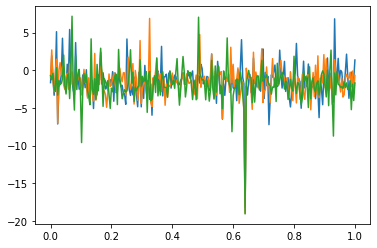

In [13]:
for n in [4,15,33]:

    encoded_vector = (np.array([xtrainencoded[n]]))
    decoded_array = np.array(autoencoder(np.array([xtrain[n]]))) #a sample file is runned through the autoencoder
    decoded_audio = irosaspec(decoded_array[0],NFFT)

    shortened_vector = shortener(np.array([xtrainencoded[n]]))
    reshaped_vector = np.array([visualizer(np.array([xtrainencoded[n]]))])
    decoded_arrayfromvect = np.array([decoder(reshaped_vector[0])])
    decoded_audiofromvect = irosaspec(decoded_arrayfromvect[0,0],NFFT)

    original = irosaspec(xtrain[n],NFFT)
    print(decoded_array.shape)

    IPython.display.display(IPython.display.Audio(original,rate = sroriginal1))
    IPython.display.display(IPython.display.Audio(decoded_audio,rate=sroriginal1))
    IPython.display.display(IPython.display.Audio(decoded_audiofromvect,rate = sroriginal1))

    plt.plot(np.linspace(0,1,256),shortened_vector[0])

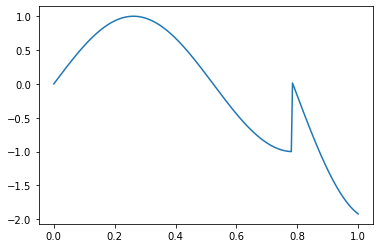

In [47]:
from numpy import linspace as lin
X = lin(0,6,256) #HEre I create a line of 256 points
probe = np.sin(X) # Here I use a given function (in this case a sine function)
for i in range(200,256): #here I can modify certain values to follow a different function
    probe[i] = -2*np.cos(X[i])
plt.plot(lin(0,1,256),probe)
plt.show()
shortened_vector = probe #then i use this modified vector and run it through all the decoders and the inverse 
                         #spectogram function
reshaped_vector = np.array([reshaper(np.array([probe]))])
decoded_arrayfromvect = np.array([decoder(reshaped_vector[0])])
decoded_audiofromvect = irosaspec(decoded_arrayfromvect[0,0],NFFT)
IPython.display.display(IPython.display.Audio(decoded_audiofromvect,rate = sroriginal1))
